## b968 - 30/06/2016 - MONSOON - LST survey

For this example we compare the brightness temperature measurements from the Heimann instrument on the aircraft with land surface temperature data from the MODIS instrument.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import datetime
import os

ROOT_DATA_PATH = '/Users/watson-parris/Desktop/cis_workshop/data/b968'

os.chdir(ROOT_DATA_PATH)

### Converting the MODIS into netCDF

In [2]:
# Show information about the hdf content
# gdalinfo MOD11A1.A2016182.h24v06.006.2016241041630.hdf
#
# extract subset from hdf5 file
# We got the exact name of the subset from the gdalinfo command above
# see: http://osgeo-org.1560.x6.nabble.com/Extract-subdataset-from-netCDF-in-a-given-directory-td5161167.html
# gdal_translate -of netCDF HDF4_EOS:EOS_GRID:"MOD11A1.A2016182.h24v06.006.2016241041630.hdf":MODIS_Grid_Daily_1km_LST:LST_Day_1km MOD11A1.A2016182.h24v06.006.2016241041630.lst.nc
#
# Convert it to WGS84 projection with longitude and latitude
# gdalwarp -of netCDF -t_srs EPSG:4326 MOD11A1.A2016182.h24v06.006.2016241041630.lst.nc MOD11A1.A2016182.h24v06.006.2016241041630.4326.lst.nc
# ncdump -h MOD11A1.A2016182.h24v06.006.2016241041630.4326.lst.nc
# ncrename -v Band1,lst MOD11A1.A2016182.h24v06.006.2016241041630.4326.lst.nc

/Users/watson-parris/anaconda/envs/cis_env3/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/Users/watson-parris/anaconda/envs/cis_env3/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


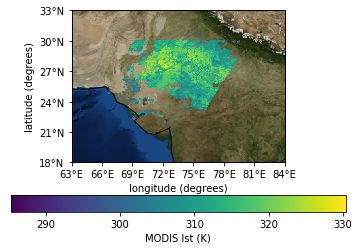

In [3]:
import cis
modis = cis.read_data(os.path.join(ROOT_DATA_PATH, 'MOD11A1.A2016182.h24v06.006.2016241041630.4326.lst.nc'), 'lst')

# scaling of the land surface temperature data
# https://gis.stackexchange.com/questions/72524/how-do-i-convert-the-lst-values-on-the-modis-lst-image-to-degree-celsius
modis.data *= 0.02

ax = modis.plot(label='MODIS lst (K)')
ax.bluemarble()

### Reading in brightness temperature from aircraft

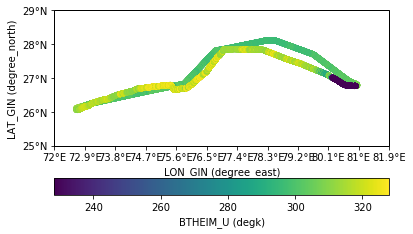

In [4]:
# reading the brightness temperature from the Heimann instrument on the FAAM aircraft
ara_bt = cis.read_data(os.path.join(ROOT_DATA_PATH, 'core_faam_20160630_v004_r0_b968_1hz_editted.nc'), 'BTHEIM_U', product='NCAR_NetCDF_RAF')
ara_bt.plot()

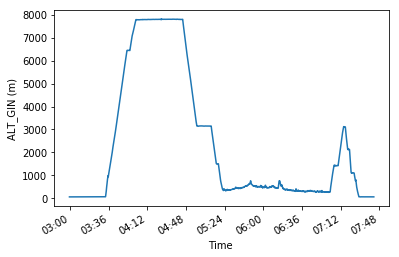

In [5]:
# reading in the gin altitude
ara_alt = cis.read_data(os.path.join(ROOT_DATA_PATH, 'core_faam_20160630_v004_r0_b968_1hz_editted.nc'), 'ALT_GIN', product='NCAR_NetCDF_RAF')

ara_alt.plot(xaxis='time')

For the further analysis we are interested in the low level leg which starts at about 05:25Z and ends at 07:00Z. Clipping the brightness data using the subset method.

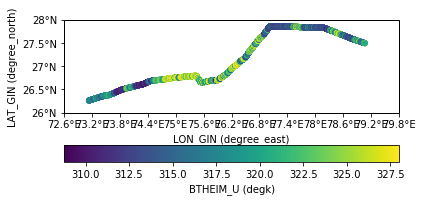

In [6]:
# Defining start and end time
stime = datetime.datetime.strptime('2016-06-30T05:25', '%Y-%m-%dT%H:%M')
etime = datetime.datetime.strptime('2016-06-30T07:00', '%Y-%m-%dT%H:%M')

# create a subset using the start and end time
ara_bt = ara_bt.subset(t=[stime, etime])
ara_bt.plot()

/Users/watson-parris/anaconda/envs/cis_env3/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/Users/watson-parris/anaconda/envs/cis_env3/lib/python3.5/site-packages/iris/coords.py:802: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


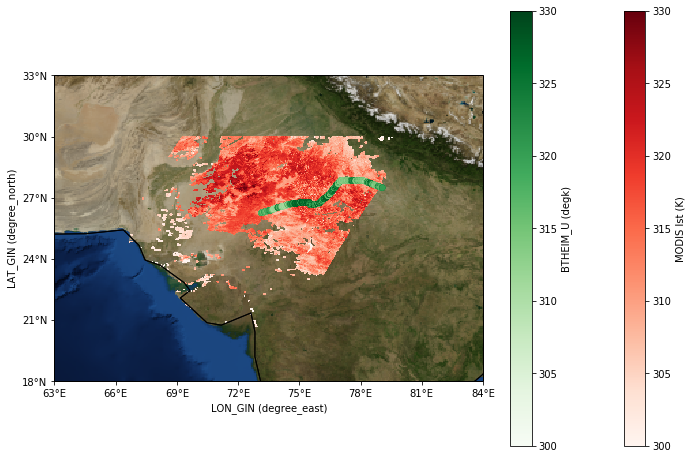

In [7]:
import cartopy.crs as ccrs
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

modis.plot(ax=ax, label='MODIS lst (K)', cmap='Reds', vmin=300, vmax=330, cbarorient='vertical')
ara_bt.plot(ax=ax, cmap='Greens', vmin=300, vmax=330, cbarorient='vertical')
ax.bluemarble()

We can create nice overlays to get a feel for the location and sampling, but if we want to pergorm a quantitive comparison we'll need to collocate the data

In [8]:
# collocate brightness temperature with MODIS. Note this time we're aggregating the aircraft data
ara_bt_col = ara_bt.collocated_onto(modis, kernel='mean')
print(ara_bt_col[0])

BTHEIM_U / (degk)                   (latitude: 1505; longitude: 2555)
     Dimension coordinates:
          latitude                           x                -
          longitude                          -                x
     Attributes:
          history: 2017-05-05T08:54:20Z Collocated onto sampling from: ['/Users/watson-parris/Desktop/cis_workshop/data/b968/MOD11A1.A2016182.h24v06.006.2016241041630.4326.lst.nc']...


/Users/watson-parris/anaconda/envs/cis_env3/lib/python3.5/site-packages/iris/analysis/cartography.py:368: UserWarning: Assuming spherical earth from ellipsoid.
  warnings.warn("Assuming spherical earth from ellipsoid.")


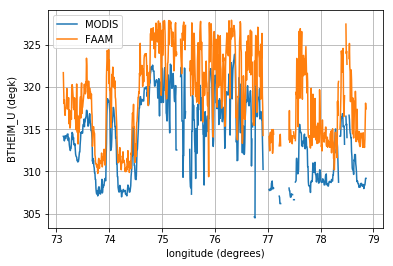

In [9]:
# copy the mask over from the brightness temperature - because of the way we did the collocation
modis.data.mask |= ara_bt_col[0].data.mask

# aggregat over the latitude dimensions
modis2 = modis.collapsed('latitude', how='mean')
ara_bt_col_meridional = ara_bt_col.collapsed('latitude', how='mean')

# plot MODIS and FAAM data against longitude for comparison
ax = modis2.plot(label='MODIS')
ara_bt_col_meridional.plot(ax=ax, label='FAAM')

ax.grid(True)

In [10]:
# Append the modis data onto our collocated data so we can plot them together easily
ara_bt_col.append(modis)

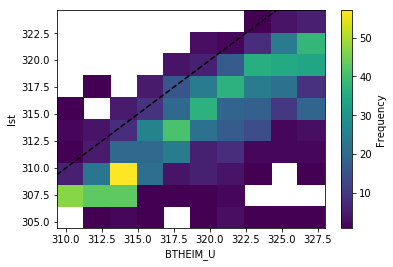

In [11]:
ara_bt_col.plot(how='histogram2d')